<a href="https://colab.research.google.com/github/hessikaveh/TabNet-Test/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Let's try the Tabnet with Ludwig and compare it with the XGBoost
**First** Lets grab the data

In [1]:
!pip install h5py

In [2]:
    # ------------------------------------------
    # load pickled numpy arrays or HDF5 as input data
    # ------------------------------------------
    def unpickle(fileName):
        # pickled and gzipped numpy arrays
        if fileName.endswith('.dmpz') or fileName.endswith('.dmp'):
            inputFile = gzip.open(fileName,'rb') if fileName.endswith('.dmpz') else open(fileName, "rb")
            try:
                data = pickle.load(inputFile, encoding='latin1')
            except:
                data = pickle.load(inputFile)
            inputFile.close()
        # HDF5 (smaller, recommended)
        elif fileName.endswith('.h5') or fileName.endswith('.hdf5'):
            data = {}
            with h5py.File(fileName, "r") as f:
                for k in ['meta', 'category_labels']:
                    data[k] = dict(json.loads(f.attrs[k])) #py3 no .decode('utf-8') needed
                for k in ['train', 'test']:
                    data[k] = {k2: f.get(k + '/' + k2)[:] for k2 in ['X', 'y']}
                    #optional: 'sample_weight', 'sample_weight_error'
                    try:
                        data[k]['sample_weight'] = f.get(k + '/sample_weight')[:]
                    except:
                        data[k]['sample_weight'] = np.full(len(data[k]['y']), 1.0, dtype=np.float32)
                    try:
                        data[k]['sample_weight_error'] = f.get(k + '/sample_weight_error')[:]
                    except:
                        data[k]['sample_weight_error'] = np.full(len(data[k]['y']), 0.0, dtype=np.float32)

                try:
                    for k in ['data']:
                        data[k] = {k2: f.get(k + '/' + k2)[:] for k2 in ['X']}
                    print("INFO: DATA included in H5 file, can make DATA/MC plots!")
                except:
                    pass

        # print meta data
        if 'meta' in data:
            print("INFO: read inputs from disk, metadata is pesent:")
            for k in sorted(data['meta'].keys()):
                print("INFO:  >  ",k,data['meta'][k])
        return data

In [37]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
# download the data
if not 'data_summer.h5' in os.listdir():
    print('Downloading data:')
    !wget https://github.com/hessikaveh/VHbbPytorch/raw/master/data_summer.h5 -O data_summer.h5
else:
    print('Data already downloaded')
    print(os.listdir())
    
# prepare the data


#df = pd.read_pickle('MadGraph.pkl')
#features = ['MET', 'pTB1', 'pTB2', 'dRBB', 'dEtaBB', 'dPhiMETdijet']
#X = df[features]
#Y = df[['Y']]
all_features = ['H_mass_fit_fallback', 'H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
features = ['H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
#data = unpickle("/content/drive/My Drive/vhbb/data_withCompleteCuts.h5")
data = unpickle("data_withCompleteCuts.h5")
X_train = data['train']['X']
Y_train = data['train']['y']
sample_weight_train = data['train']['sample_weight']
sample_weight_train = pd.DataFrame(sample_weight_train, columns=['weight'])
X_train = pd.DataFrame(X_train, columns=all_features)
Y_train = pd.DataFrame(Y_train, columns=['Y'])
Z_train = X_train[['H_mass_fit_fallback']]

X_test = data['test']['X']
Y_test = data['test']['y']
sample_weight_test = data['test']['sample_weight']
sample_weight_test = pd.DataFrame(sample_weight_test, columns=['weight'])
X_test = pd.DataFrame(X_test, columns=all_features)
Y_test = pd.DataFrame(Y_test, columns=['Y'])
Z_test = X_test[['H_mass_fit_fallback']]

del X_test['H_mass_fit_fallback']
del X_train['H_mass_fit_fallback']

#print(Z)
# preprocessing
X = pd.concat([X_train, X_test],axis=0, join='inner')
Y = pd.concat([Y_train, Y_test],axis=0, join='inner')
Z = pd.concat([Z_train, Z_test],axis=0, join='inner')
X_pca = PCA(X.shape[1], svd_solver='auto', whiten=True)
Z_pca = PCA(Z.shape[1], svd_solver='auto', whiten=True)

X_pca.fit(X)
Z_pca.fit(Z)
df = pd.concat([X, Y],axis=1)
df_train = pd.concat([X_train, Y_train],axis=1)
df_test = pd.concat([X_test, Y_test],axis=1)

print (df)
# split
#X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z)

def generate_hbb(n_samples, train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test
    weights_full = sample_weight_train if train else sample_weight_test
    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
    weights = weights_full.sample(n_samples, random_state=random_state)
    # preprocess them
    #return X_pca.transform(X), Y.values, Z_pca.transform(Z), weights.values
    return X.values, Y.values, Z.values, weights.values
X, Y, Z, weights = generate_hbb(500, train=True)

Data already downloaded
['.config', 'tutorial.json', 'higgs.yml', 'temp.png', 'higgs.yaml', 'tutorial.h5', 'data_withCompleteCuts.h5', 'results', 'data_summer.h5', '.ipynb_checkpoints', 'medium_config.yaml', 'tutorial-progress.h5', 'higgs.csv', 'sample_data']
INFO: read inputs from disk, metadata is pesent:
INFO:  >   variables H_mass_fit_fallback H_pt_fit_fallback V_pt nAddJets_2lep SA5 V_mass MET_Pt hJets_leadingPt hJets_subleadingPt jjVPtRatio HJ1_HJ2_dEta HVdPhi_fit_fallback hJets_btagged_0 hJets_btagged_1 HJ1_HJ2_dR n_recoil_jets_fit H_mass_sigma_fit
        H_pt_fit_fallback        V_pt  ...  H_mass_sigma_fit    Y
0              227.006790  229.563721  ...         17.820295  1.0
1              153.907333  154.488251  ...         10.239766  1.0
2              155.563187  190.107605  ...         11.275752  1.0
3               18.904070  201.898819  ...          0.397262  1.0
4              169.643005  168.136353  ...         19.277073  1.0
...                   ...         ...  ...

### Show the data

Here, let's take a look at a few kinematic variables for the signal and background samples.

H_pt_fit_fallback
V_pt
nAddJets_2lep
SA5
V_mass
MET_Pt
hJets_leadingPt
hJets_subleadingPt
jjVPtRatio
HJ1_HJ2_dEta
HVdPhi_fit_fallback
hJets_btagged_0
hJets_btagged_1
HJ1_HJ2_dR
n_recoil_jets_fit
H_mass_sigma_fit


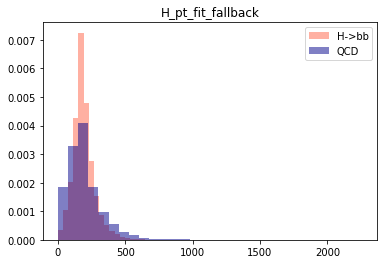

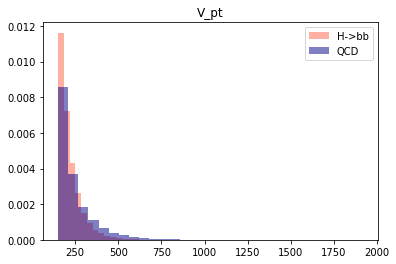

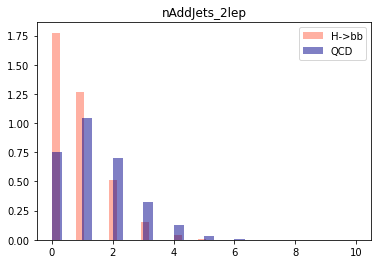

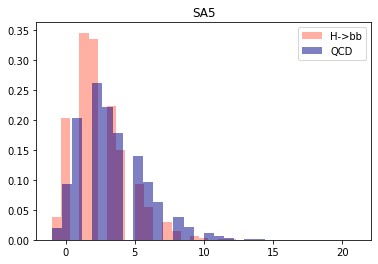

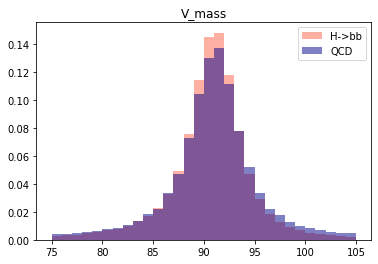

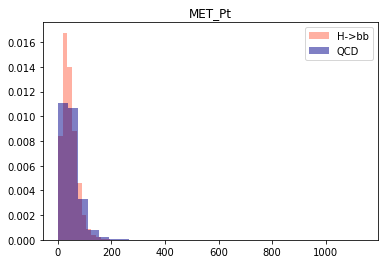

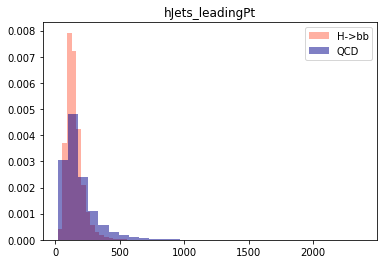

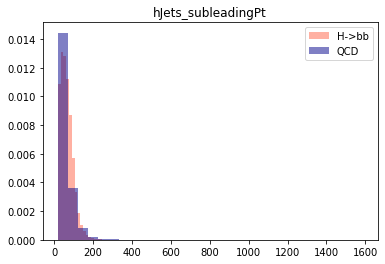

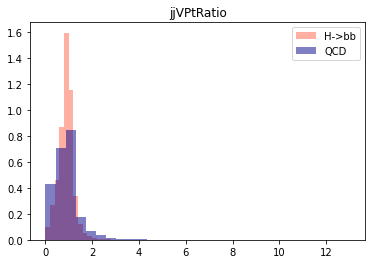

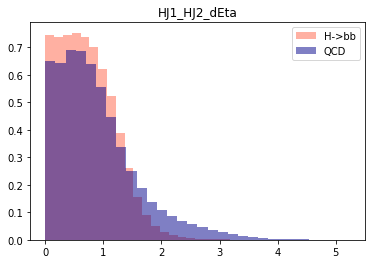

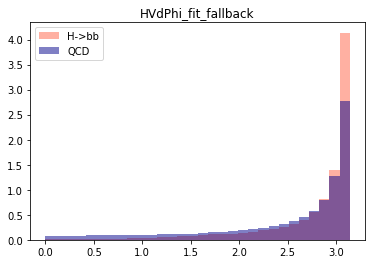

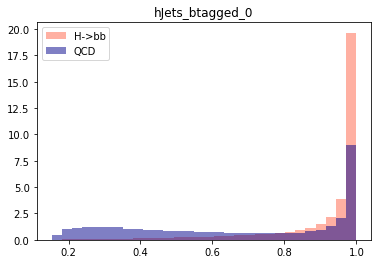

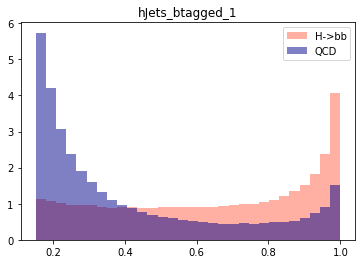

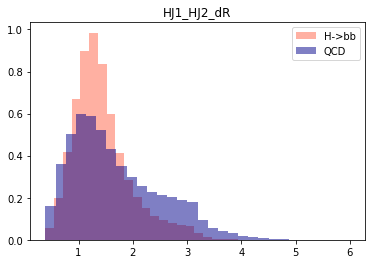

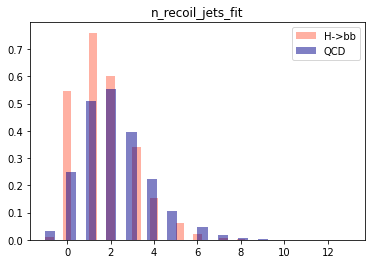

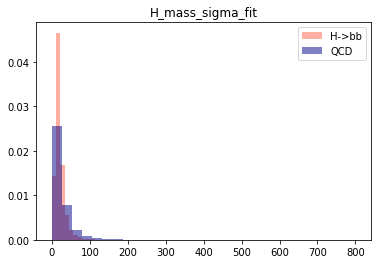

In [4]:
for feature in features:
    fig, ax = plt.subplots()
    print(feature)
    _ = ax.hist(df.query('Y==1')[feature], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb')
    _ = ax.hist(df.query('Y==0')[feature], bins=30, alpha=0.5, density=True, color='darkblue', label='QCD')
    ax.set_title(feature)
    ax.legend(loc='best')

### XGBoost

[18:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


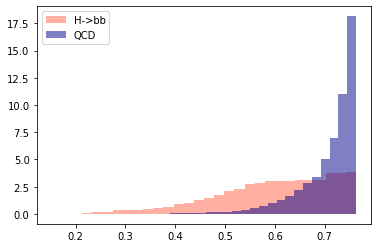

In [5]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,Y_train)

preds = xg_reg.predict(X_test)
weights = pd.concat([sample_weight_test, Y_test], axis=1)
yhat_df = pd.DataFrame(preds)
yhat_pred = pd.concat([yhat_df, Y_test], axis=1)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==0]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='darkblue', label='QCD', weights =[ weights[weights['Y']==1]['weight'] ])
ax.legend()

In [6]:
# define the model
model = XGBClassifier()
# define the datasets to evaluate each iteration
evalset = [(X_train, Y_train), (X_test,Y_test)]
# fit the model
model.fit(X_train, Y_train, eval_metric='logloss', eval_set=evalset)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-logloss:0.646712	validation_1-logloss:0.646809
[1]	validation_0-logloss:0.608314	validation_1-logloss:0.608472
[2]	validation_0-logloss:0.57833	validation_1-logloss:0.578477
[3]	validation_0-logloss:0.552107	validation_1-logloss:0.5523
[4]	validation_0-logloss:0.529118	validation_1-logloss:0.529352
[5]	validation_0-logloss:0.511065	validation_1-logloss:0.511378
[6]	validation_0-logloss:0.494984	validation_1-logloss:0.495372
[7]	validation_0-logloss:0.48076	validation_1-logloss:0.481196
[8]	validation_0-logloss:0.469126	validation_1-logloss:0.469589
[9]	validation_0-logloss:0.458993	validation_1-logloss:0.459506
[10]	validation_0-logloss:0.450324	validation_1-logloss:0.450815
[11]	validation_0-logloss:0.44251	validation_1-logloss:0.443042
[12]	validation_0-logloss:0.435738	validation_1-logloss:0.436332
[13]	validation_0-logloss:0.429869	validation_1-logloss:0.430486
[14]	validation_0-logloss:0.4249	validation_1-logloss:0.425495
[15]	validation_0-logloss:0.420577	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [7]:
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(Y_test, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 0.853


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(20, activation="relu", name="layer1"),
        layers.Dense(32, activation="relu", name="layer2"),
        layers.Dense(10, activation="relu", name="layer3"),
        layers.Dense(2, activation="sigmoid", name="layer4"),
    ]
)


In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'temp.png', show_shapes=True)

model.compile('adam', 'sparse_categorical_crossentropy')
 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
print( Counter(Y_test) )
# uneven classes

print('Training:')
try:
    model.fit(
        X_train, Y_train,
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=10, 
        validation_split = 0.2,
        verbose=True
) 
except KeyboardInterrupt:
    print( 'Training ended early.' )
# -- load in best network
model.load_weights('tutorial-progress.h5')

# -- Save network weights and structure
print( 'Saving model...' )
model.save_weights('tutorial.h5', overwrite=True)
json_string = model.to_json()
open('tutorial.json', 'w').write(json_string)
print( 'Done' )

print( 'Testing...' )
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

# predictions
print(yhat)

Counter({'Y': 1})
Training:
Epoch 1/10
8080/8080 [==============================] - 13s 2ms/step - loss: 0.1129 - val_loss: 5.2381

Epoch 00001: val_loss improved from inf to 5.23806, saving model to tutorial-progress.h5
Epoch 2/10
8080/8080 [==============================] - 11s 1ms/step - loss: 0.0930 - val_loss: 4.7687

Epoch 00002: val_loss improved from 5.23806 to 4.76870, saving model to tutorial-progress.h5
Epoch 3/10
8080/8080 [==============================] - 12s 2ms/step - loss: 0.0909 - val_loss: 4.2279

Epoch 00003: val_loss improved from 4.76870 to 4.22788, saving model to tutorial-progress.h5
Epoch 4/10
8080/8080 [==============================] - 11s 1ms/step - loss: 0.0903 - val_loss: 4.5362

Epoch 00004: val_loss did not improve from 4.22788
Epoch 5/10
8080/8080 [==============================] - 11s 1ms/step - loss: 0.0897 - val_loss: 3.8817

Epoch 00005: val_loss improved from 4.22788 to 3.88168, saving model to tutorial-progress.h5
Epoch 6/10
8080/8080 [===========

In [10]:
yhat = model.predict(X_test)
yhat_cls = np.argmax(yhat, axis=1)
score = accuracy_score(Y_test, yhat_cls)
print('Accuracy: %.3f' % score)

Accuracy: 0.783


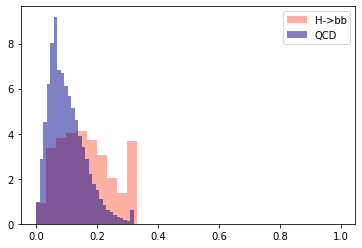

In [11]:
# -- turn them into classes
yhat_cls = np.argmax(yhat, axis=1)

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion.png")

#print(yhat[:,0])
#print(yhat[:,1])
weights = pd.concat([sample_weight_test, Y_test], axis=1)
yhat_df = pd.DataFrame(yhat)
yhat_pred = pd.concat([yhat_df, Y_test], axis=1)
#print(weights[weights['Y']==1]['weight'], yhat_pred)
# Compute confusion matrix
#cnf_matrix = confusion_matrix(Y_test, yhat, sample_weight=sample_weight_test)
#cnf_matrix = confusion_matrix(Y_test, yhat_cls)
#np.set_printoptions(precision=2)
#plot_confusion_matrix(cnf_matrix, classes=['Hbb', 'Bkg'],
#                      normalize=True,
#                      title='Normalized confusion matrix')
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
#print ('Signal efficiency:', sample_weight_test[(yhat == 0)].sum() / sample_weight_test[yhat == 0].sum())

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = weights[(Y_test != 0) ].sum() / weights[Y_test != 0].sum()
#print ('Background efficiency:', b_eff)
#print ('Background rej:', 1 / b_eff)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==0]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='darkblue', label='QCD', weights =[ weights[weights['Y']==1]['weight'] ])
ax.legend()

In [12]:
document="""
input_features:
  - name: H_pt_fit_fallback
    type: numerical
  - name: V_pt
    type: numerical
  - name: nAddJets_2lep
    type: numerical
  - name: SA5
    type: numerical
  - name: V_mass
    type: numerical
  - name: MET_Pt
    type: numerical
  - name: hJets_leadingPt
    type: numerical
  - name: hJets_subleadingPt
    type: numerical
  - name: jjVPtRatio
    type: numerical
  - name: HJ1_HJ2_dEta
    type: numerical
  - name: HVdPhi_fit_fallback
    type: numerical
  - name: hJets_btagged_0
    type: numerical
  - name: hJets_btagged_1
    type: numerical
  - name: HJ1_HJ2_dR
    type: numerical
  - name: n_recoil_jets_fit
    type: numerical
  - name: H_mass_sigma_fit
    type: numerical
output_features:
  - name: label
    type: binary
    weight_regularization: null
combiner:
  type: tabnet
  size: 32  # N_a
  output_size: 96  # N_d
  sparsity: 0.000001  # lambda_sparse
  bn_virtual_divider: 32  # factor to divide batch_size B to get B_v from the paper
  bn_momentum: 0.9  # m_B
  num_steps: 8  # N_steps
  relaxation_factor: 2  # gamma
  use_keras_batch_norm: false
  bn_virtual_bs: 256  # B_v 
training:
  batch_size: 8192  # B
  eval_batch_size: 500000  # 65536 131072 262144 524288
  epochs: 1000
  early_stop: 20
  learning_rate: 0.025
  optimizer:
    type: adam
  decay: true
  decay_steps: 10000
  decay_rate: 0.9
  staircase: true
  regularization_lambda: 1
  validation_field: label
  shuffle_buffer_size: 1500000
"""

In [43]:
import yaml
yaml_data = {'input_features': [{'name': 'H_pt_fit_fallback', 'type': 'numerical'}, {'name': 'V_pt', 'type': 'numerical'}, {'name': 'nAddJets_2lep', 'type': 'numerical'}, {'name': 'SA5', 'type': 'numerical'}, {'name': 'V_mass', 'type': 'numerical'}, {'name': 'MET_Pt', 'type': 'numerical'}, {'name': 'hJets_leadingPt', 'type': 'numerical'}, {'name': 'hJets_subleadingPt', 'type': 'numerical'}, {'name': 'jjVPtRatio', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dEta', 'type': 'numerical'}, {'name': 'HVdPhi_fit_fallback', 'type': 'numerical'}, {'name': 'hJets_btagged_0', 'type': 'numerical'}, {'name': 'hJets_btagged_1', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dR', 'type': 'numerical'}, {'name': 'n_recoil_jets_fit', 'type': 'numerical'}, {'name': 'H_mass_sigma_fit', 'type': 'numerical'}], 'output_features': [{'name': 'Y', 'type': 'binary', 'weight_regularization': None}], 'combiner': {'type': 'tabnet', 'size': 32, 'output_size': 96, 'sparsity': 1e-06, 'bn_virtual_divider': 32, 'bn_momentum': 0.9, 'num_steps': 8, 'relaxation_factor': 2, 'use_keras_batch_norm': False, 'bn_virtual_bs': 256}, 'training': {'batch_size': 8192, 'eval_batch_size': 500000, 'epochs': 1000, 'early_stop': 20, 'learning_rate': 0.025, 'optimizer': {'type': 'adam'}, 'decay': True, 'decay_steps': 10000, 'decay_rate': 0.9, 'staircase': True, 'regularization_lambda': 1, 'validation_field': 'Y', 'shuffle_buffer_size': 1500000}}

# Write YAML file
with open('higgs.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(yaml_data, outfile, default_flow_style=False, allow_unicode=True)

In [44]:
# Read YAML file
with open("higgs.yaml", 'r') as stream:
    yml_loaded = yaml.safe_load(stream)

print(yml_loaded)

{'combiner': {'bn_momentum': 0.9, 'bn_virtual_bs': 256, 'bn_virtual_divider': 32, 'num_steps': 8, 'output_size': 96, 'relaxation_factor': 2, 'size': 32, 'sparsity': 1e-06, 'type': 'tabnet', 'use_keras_batch_norm': False}, 'input_features': [{'name': 'H_pt_fit_fallback', 'type': 'numerical'}, {'name': 'V_pt', 'type': 'numerical'}, {'name': 'nAddJets_2lep', 'type': 'numerical'}, {'name': 'SA5', 'type': 'numerical'}, {'name': 'V_mass', 'type': 'numerical'}, {'name': 'MET_Pt', 'type': 'numerical'}, {'name': 'hJets_leadingPt', 'type': 'numerical'}, {'name': 'hJets_subleadingPt', 'type': 'numerical'}, {'name': 'jjVPtRatio', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dEta', 'type': 'numerical'}, {'name': 'HVdPhi_fit_fallback', 'type': 'numerical'}, {'name': 'hJets_btagged_0', 'type': 'numerical'}, {'name': 'hJets_btagged_1', 'type': 'numerical'}, {'name': 'HJ1_HJ2_dR', 'type': 'numerical'}, {'name': 'n_recoil_jets_fit', 'type': 'numerical'}, {'name': 'H_mass_sigma_fit', 'type': 'numerical'}], 'o

In [45]:
print(df.head())

   H_pt_fit_fallback        V_pt  ...  H_mass_sigma_fit    Y
0         227.006790  229.563721  ...         17.820295  1.0
1         153.907333  154.488251  ...         10.239766  1.0
2         155.563187  190.107605  ...         11.275752  1.0
3          18.904070  201.898819  ...          0.397262  1.0
4         169.643005  168.136353  ...         19.277073  1.0

[5 rows x 17 columns]


In [41]:
!pip install ludwig
!pip install petastorm


Uninstalling ludwig-0.4:
  Successfully uninstalled ludwig-0.4
Processing /root/.cache/pip/wheels/eb/c3/fd/e4650be37a75afd05b639d747b479e041583e8cc6fc8f71b63/ludwig-0.4-cp37-none-any.whl


In [35]:
df.to_csv("higgs.csv")

In [ ]:
!ludwig train --dataset higgs.csv --config higgs.yaml


2021-07-04 18:59:45.627841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.4 - Train

2021-07-04 18:59:46.868701: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-04 18:59:46.878404: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-04 18:59:46.878444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (776879d77f83): /proc/driver/nvidia/version does not exist
Experiment name: experiment
Model name: run
Output directory: results/experiment_run_1


ludwig_version: '0.4'
command: '/usr/local/bin/ludwig train --dataset 